In [18]:
import numpy as np
import glob
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
from minpy.context import cpu, gpu

In [19]:
class Neural_Net:
    
    def __init__(self):
        self.layers = list()
        
    def add_layer(self, neurons, activation = 'sigmoid'):
        self.layers.append( Layer(neurons, activation = activation))
        
    def set_input(self, inp):
        self.inp = inp
        self.train_inp = inp
        self.feed_forward()
        
    def set_output(self, out):
        self.out = out
        self.train_out = out
        
        
    def feed_forward(self):
        self.layers[0].set_input(self.train_inp)
        for i in range(1, len(self.layers) ):
            (self.layers[i]).set_input(self.layers[i-1].output)
        
        
        
    def back_propagation(self, lr):
        tensor = list()
        tensor.append(self.diff())
        for i in reversed(range(0, len(self.layers) - 1)):
            
            tensor.append(np.multiply(
                np.matmul(tensor[-1], np.transpose(self.layers[i+1].weights)),
                self.layers[i].d_output
                ))
        
        tensor = tensor[::-1]
        for i in range(len(tensor)):
            self.layers[i].weights -= lr*np.matmul(np.transpose(self.layers[i].inp), tensor[i])
            self.layers[i].bias -= lr*np.matmul(np.transpose(self.layers[i].A), tensor[i])
        
    def train(self, epochs, lr = 1, batch_size = None):
        if batch_size is None:
            batch_size = self.inp.shape[0]
        partitions = int(self.inp.shape[0]/batch_size)
        limits = np.linspace(0, self.inp.shape[0], partitions + 1, dtype= int)
        
            
        for epoch in range(epochs):
            print('epoch = ', epoch)
            for partition in range(partitions):
                
                
                self.train_inp = self.inp[int(limits[partition]):int(limits[partition + 1])]
                self.train_out = self.out[int(limits[partition]):int(limits[partition + 1])]
                for j in range(1000):
                    self.feed_forward()
                    self.back_propagation(lr)
            
            self.train_inp = self.inp
            self.train_out = self.out
            self.feed_forward()
            
            self.cost = np.sum((self.diff()**2))
            print(self.cost)
            
    def diff(self):
        return self.layers[-1].output - self.train_out
        

In [20]:
class Layer:
    
    @staticmethod
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    
    @staticmethod
    def relu(x):
        
        return np.where(x < 0, 0, x )
    
    @staticmethod
    def d_sigmoid(x):
        a = Layer.sigmoid(x)
        return a*(1-a)
    
    @staticmethod
    def d_relu(x):
        
        return np.where(x<0, 0, 1)
    
    function = { 'sigmoid': (lambda x: Layer.sigmoid(x)), 'relu': (lambda x: Layer.relu(x))}
    
    d_function = { 'sigmoid': (lambda x: Layer.d_sigmoid(x)), 'relu': (lambda x: Layer.d_relu(x)) }


    def __init__(self, neurons, inp = None, activation = 'sigmoid'):
        self.init = False
        self.neurons = neurons
        self.inp = self.set_input(inp)
        self.activation = activation
        
        
    def set_input(self, inp):
        if (inp is None):
            return None
        
        if (self.init == False):
            self.weights = np.random.rand(inp.shape[1], self.neurons)
            print (self.weights)
            self.bias = np.random.rand(1, self.neurons)
            
            self.init = True
            
        self.inp = inp
        self.A = np.ones((inp.shape[0], 1))
        self.linear = np.add(
                        np.matmul(self.inp, self.weights), 
                        np.matmul(self.A, self.bias)
                        )
        self.output = Layer.function[self.activation](self.linear)
        self.d_output = Layer.d_function[self.activation](self.linear)

# Define Model

In [21]:
a = Neural_Net()

## Build Model parameters

In [22]:

a.add_layer(8, activation = 'relu')
a.add_layer(1, activation = 'sigmoid')

# Let's make and XNOR  gate

In [23]:
inp = np.array([[0, 0], [0, 1], [1,0], [1,1]])

In [24]:
out = np.array([[1], [0], [0], [1]])

In [25]:
a.set_input(inp)
a.set_output(out)

[[0.58889288 0.47376254 0.42974153 0.51710492 0.8060513  0.17515864
  0.73220198 0.18879887]
 [0.18107061 0.98931447 0.71781734 0.91544777 0.07144451 0.88069144
  0.89127948 0.77244956]]
[[0.03530982]
 [0.28301188]
 [0.39276928]
 [0.32421123]
 [0.73555271]
 [0.50611345]
 [0.6732969 ]
 [0.27859633]]


In [26]:
a.train(epochs = 10, lr = 1e-3)

epoch =  0
0.9963036315786136
epoch =  1
0.9879418622594132
epoch =  2
0.9736549014694793
epoch =  3
0.9476677467595016
epoch =  4
0.9010690525487753
epoch =  5
0.8243300421344222
epoch =  6
0.7325667177090589
epoch =  7
0.6311354488259606
epoch =  8
0.5286144977062928
epoch =  9
0.43261754298066907


In [27]:
a.layers[0].weights

array([[ 0.79208751,  0.60456961,  0.42455054,  0.58953859,  0.48712444,
         1.41549622,  0.61832473,  0.19256353],
       [ 0.25237951,  1.01867984,  0.69075229,  0.91743683, -0.10212221,
         1.41622698,  0.80164346,  0.75624703]])

In [28]:
np.round(a.layers[1].output, 0)

array([[1.],
       [0.],
       [0.],
       [1.]])

## Let's use the mnist dataset

In [29]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist



In [30]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape(-1, 28*28) / 255.0, x_test.reshape(-1, 28*28) / 255.0
y_train = np.transpose(np.array([np.where(y_train == element, 1, 0) for element in np.unique(y_train)]))
y_test = np.transpose(np.array([np.where(y_test == element, 1, 0) for element in np.unique(y_test)]))

In [31]:
y_train[1]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

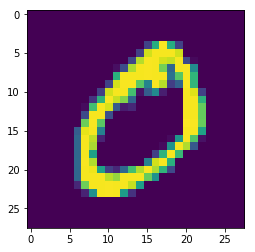

In [32]:
plt.imshow(x_train[1].reshape(28, 28))

## Use GPU 

In [33]:
import minpy.numpy as np
from minpy.context import cpu, gpu
import time
with gpu(0):
    model = Neural_Net()
    model.add_layer(10, activation = 'sigmoid')
    model.set_input(np.array(x_train))
    model.set_output(np.array(y_train))
    t2 = time.time()
    model.train(lr = 1e-5, epochs = 2, batch_size = None)
    t3 = time.time()

[[0.8554306  0.01817834 0.80255087 ... 0.01298254 0.33946762 0.32260299]
 [0.24754352 0.82735689 0.63810578 ... 0.54181062 0.49049085 0.8923982 ]
 [0.20616849 0.1075222  0.31719937 ... 0.42623588 0.33633214 0.75754921]
 ...
 [0.87316252 0.24680865 0.04468423 ... 0.59841681 0.68312849 0.02899333]
 [0.22556358 0.75836759 0.84071409 ... 0.18099462 0.05642617 0.8972032 ]
 [0.46424953 0.50116017 0.97124436 ... 0.53323184 0.44233326 0.7414268 ]]
epoch =  0
[11409.793]
epoch =  1
[10494.833]


# Use CPU 

In [34]:
import numpy as np
import time
model = Neural_Net()
model.add_layer(10, activation = 'sigmoid')
model.set_input(x_train)
model.set_output(y_train)
t0 = time.time()
model.train(lr = 1e-5, epochs = 2, batch_size = None)
t1 = time.time()

[[0.39802325 0.4449126  0.96094542 ... 0.98182622 0.40138386 0.25742123]
 [0.67000866 0.38579929 0.67823219 ... 0.98468189 0.97933294 0.88752439]
 [0.71458113 0.89763371 0.31099804 ... 0.87920508 0.52658276 0.16994142]
 ...
 [0.61983326 0.7223776  0.7621549  ... 0.03037107 0.38009689 0.20837013]
 [0.9279087  0.20387268 0.44302711 ... 0.05527384 0.24797472 0.76075655]
 [0.10980709 0.29190936 0.29814861 ... 0.86431775 0.0392903  0.07748252]]
epoch =  0
11413.97518886999
epoch =  1
10501.94518629532


In [35]:
print("run on cpu: %.6f s/iter" % ((t1 - t0)))
print("run on gpu: %.6f s/iter" % ((t3 - t2)))

run on cpu: 233.396916 s/iter
run on gpu: 359.417505 s/iter


## Accuracy 

In [36]:
model.set_input(x_train)
model.set_output(y_train)
model.feed_forward()
predict = np.argmax(model.layers[-1].output, axis=1)
y = np.argmax(y_train, axis=1)
accuracy = (y == predict)
score = sum(np.where(accuracy == True, 1, 0))/len(y)
print('Train Accuracy =', score)

Train Accuracy = 0.9135333333333333


In [37]:
model.set_input(x_test)
model.set_output(y_test)
model.feed_forward()
predict = np.argmax(model.layers[-1].output, axis=1)
y = np.argmax(y_test, axis=1)
accuracy = (y == predict)
score = sum(np.where(accuracy == True, 1, 0))/len(y)
print('Test Accuracy =', score)

Test Accuracy = 0.9162
